<a href="https://colab.research.google.com/github/Ken-huea/image-recognition/blob/main/CNN%E5%88%86%E9%A1%9E(mnist)%E2%91%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要や仕組み理解

### 畳み込みニューラルネットワーク（<font color="red">CNN</font>:Convolutional Neural Network)
[動画はこちら](https://www.youtube.com/watch?v=VXswOMVS1gA)


ディープラーニングの手法の１つで、主に画像認識に利用されています。

ニューラルネットワークの重み計算に「畳み込み演算（Convolution）」が用いられていることから、CNNと呼ばれています。

画像処理が得意みたい。

犬猫分類や手書き文字の分類。

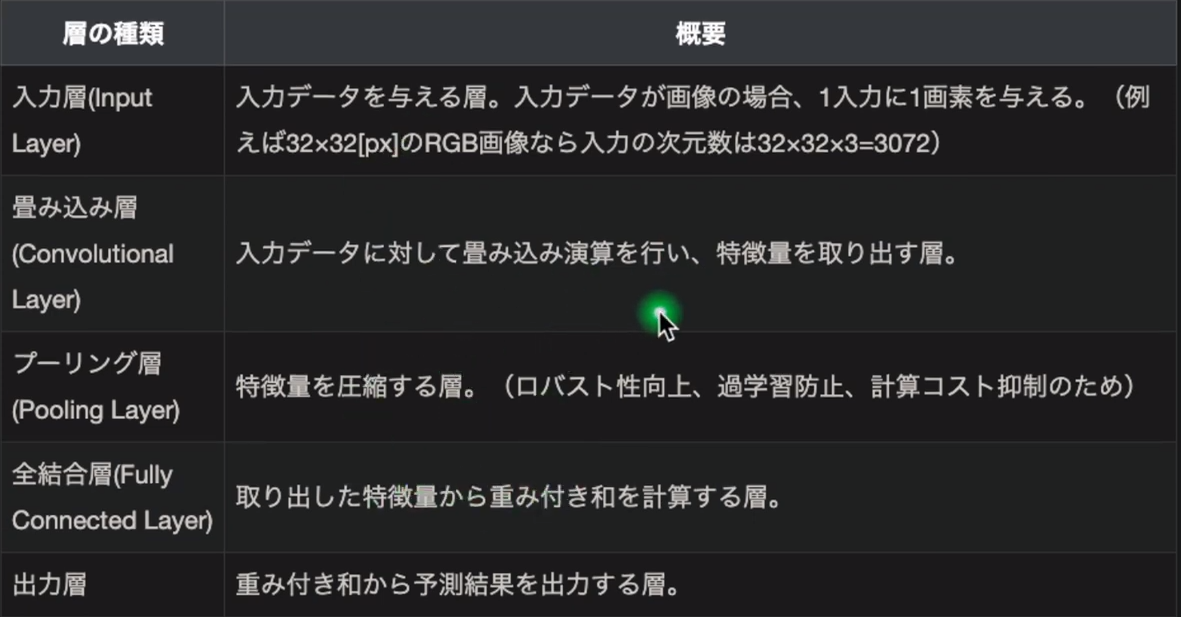

①：入力データと同じ次元数で

②：畳み込み演算を行い画像の特徴量を抽出する。エッジや輪郭を取り出す。
輪郭は画像の特徴を良く示しているから。

③特徴量データを圧縮してデータも圧縮。ロバストして誤差に強くなる。

④

⑤出力層を答えにする。答を取り出す。

##### 畳み込み演算

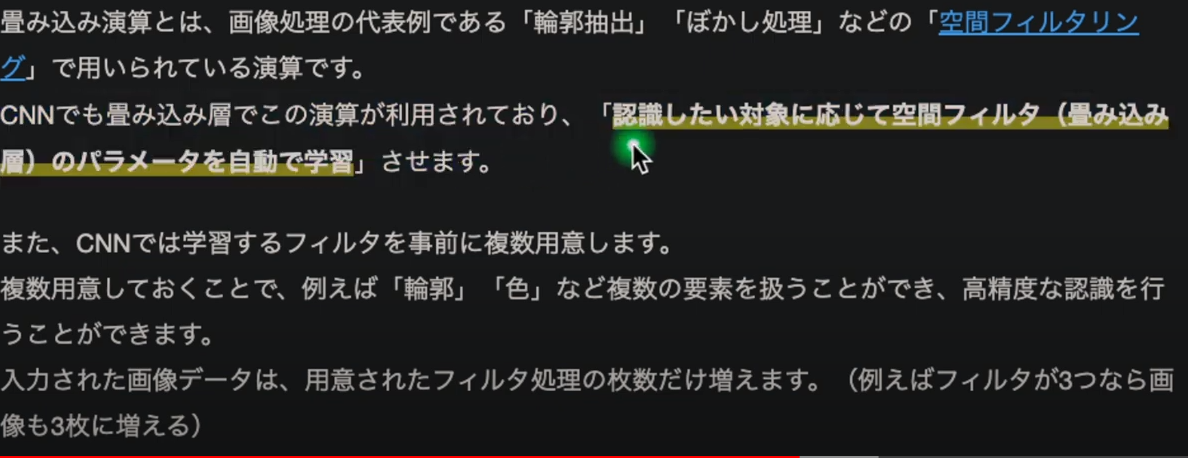

カーネルのサイズや個数は自分で調整するが、フィルターの値は自動で調整してくれる。

畳み込み演算について。

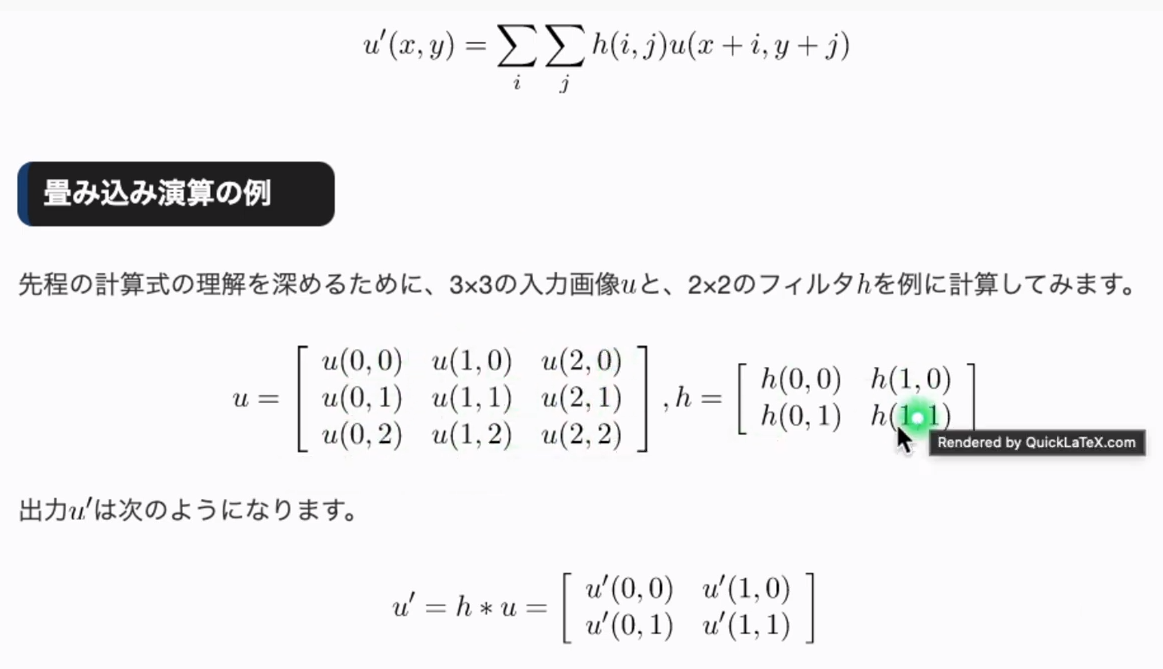

入力画像  ：u　　3*3の

フィルター：h　　2*2 　これがカーネルの値。

畳み込み演算を行った結果の出力はU'になりますよと。　行列の掛け算かな？

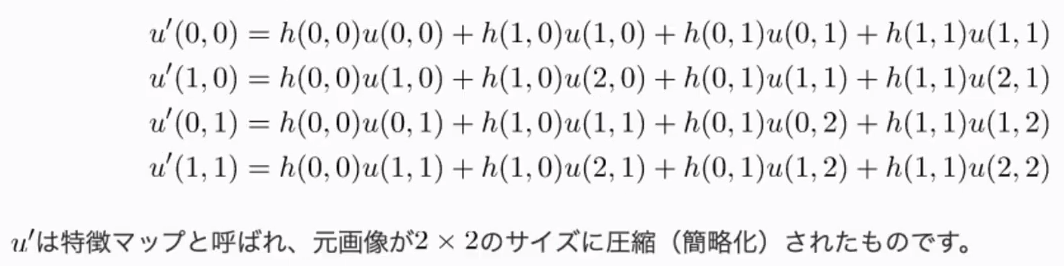

今回は入力画像が2次元だったけど、実際は<font color="red">カラーなので3次元</font>の方が圧倒的に多い。

その場合はRGBそれぞれに対して畳み込み演算を行います。

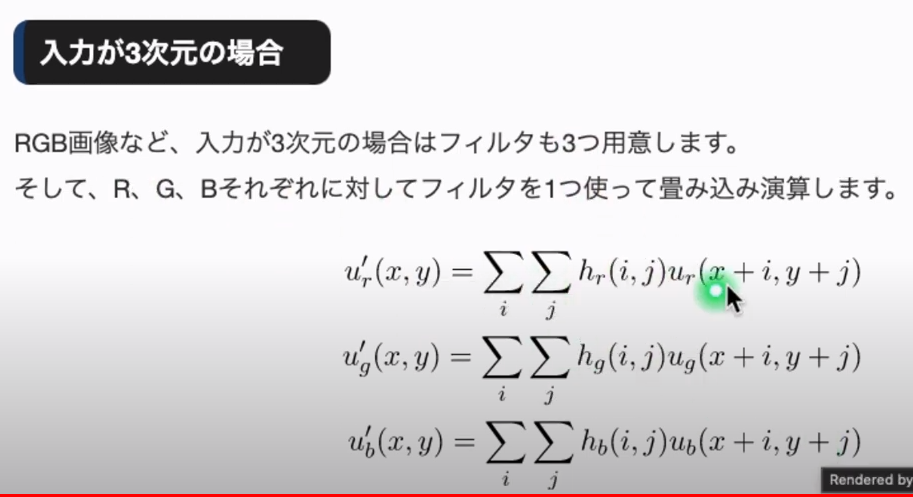

##### ゼロパディング処理

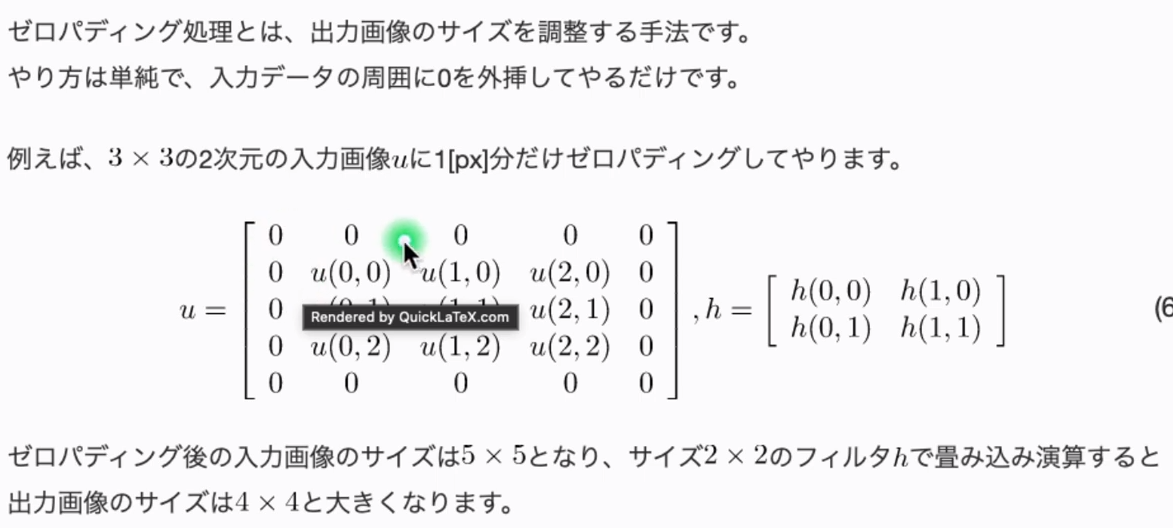

周りに0を外挿すると、3×3の行列が、5×5の行列になりますね。

出力する特徴の次元数を調整する為になる。

例：2×２から４×４にできましたよと。

行列の掛け算をすると、4×４の出力になりますよと。

##### ストライド

畳み込み演算を行う際のフィルタの移動量を変化させる事。

上記の処理のずらしを1つづズラす、３つづズラす等。

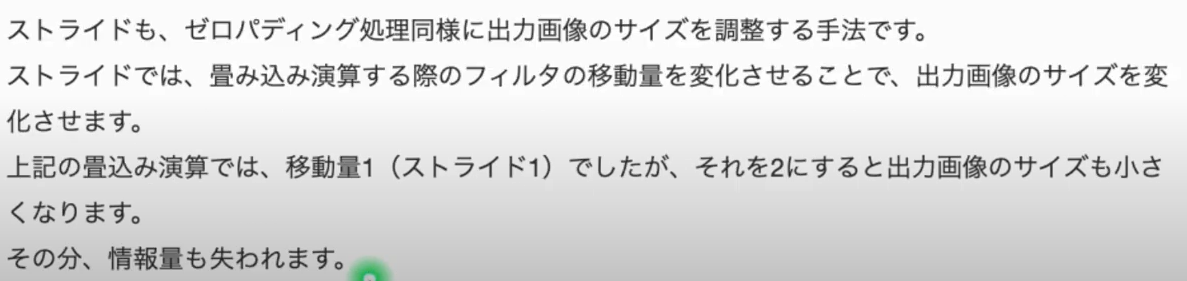

##### プーリング層

畳み込み後に入力データの圧縮を行う。

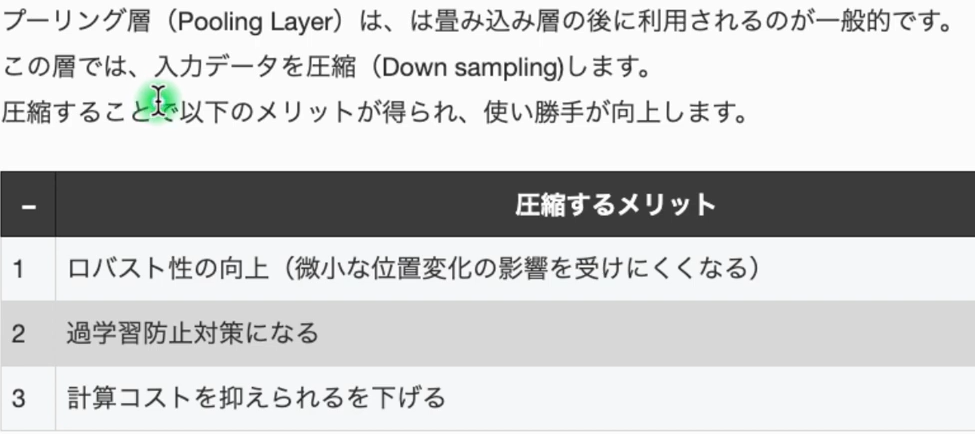

圧縮する方法はいくつかあります。

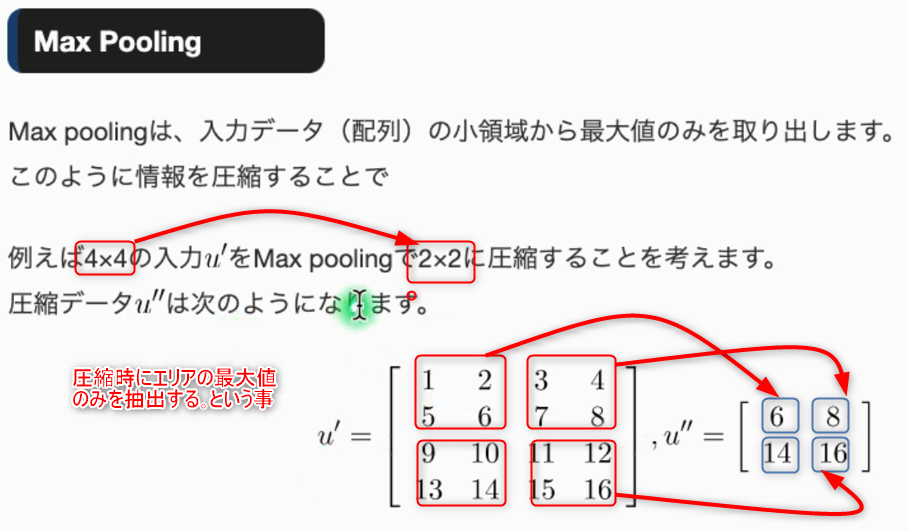

##### 全結合層

出力層で識別を行う。

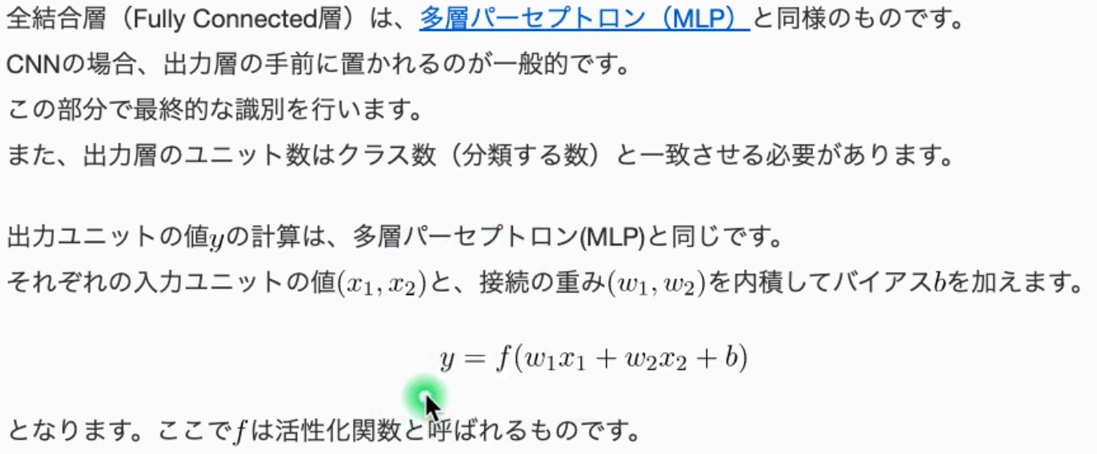

### mnistとは

「6万枚の手書き数字の学習用画像」と「1万枚のテスト画像」が格納されています。

これらの画像は全て28×28[px]のグレースケール画像

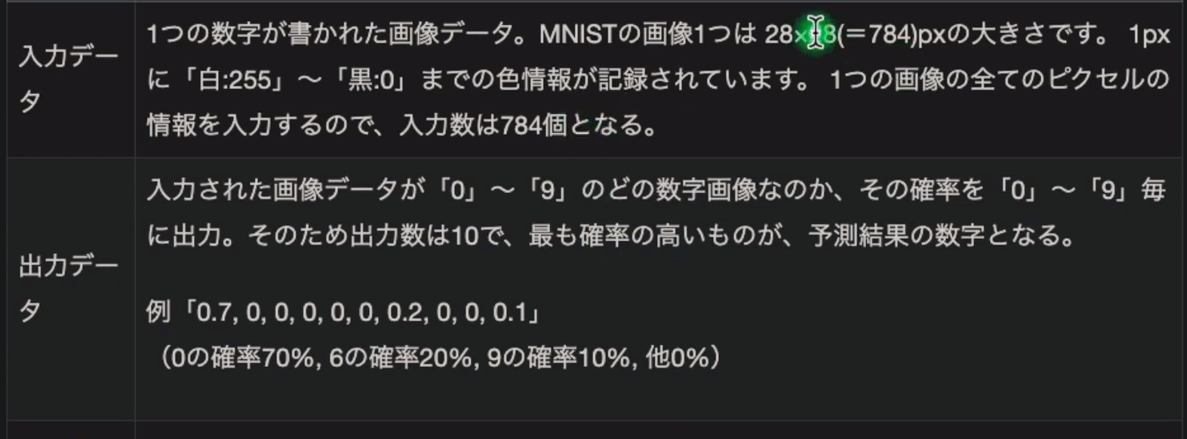

# 実装

[こちらを参考](https://www.youtube.com/watch?v=VXswOMVS1gA&list=PL1P-NJggk9lbilEP-IHapQRCdYlvX43yC&index=106)

### 準備
モジュールインポート、データの取得と整形

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import pickle

データを読み込んだら確認も。取得した画像はグレースケール(白黒)という事が分かりますね。

因みにカラー画像ならば28＊28＊3になるはずです。今回は28＊28

In [ ]:
# データセット（訓練用データとテスト用データ）をネットから取得
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.shape, y_train.shape,x_test.shape, y_test.shape
print("訓練データの画像データ",x_train.shape) # 28*28pxの60000枚。
print("訓練データの正解ラベル",y_train.shape) # 60000枚で１～９
print("テストデータの画像データ",x_test.shape) # 28*28pxの10000枚。
print("テストデータの正解ラベル",y_test.shape) # 10000枚で１～９

11501568/11490434 [==============================] - 0s 0us/step
訓練データの画像データ (60000, 28, 28)
訓練データの正解ラベル (60000,)
テストデータの画像データ (10000, 28, 28)
テストデータの正解ラベル (10000,)


画像データの加工。


- そのデータ型をfloat32(浮動小数点型)に変換
- 取得したデータを、2次元配列から1次元配列へ変換（今回は28*28=784個の要素数)

これらの処理はディープラーニングに組み込む上での必要な処理です。


In [ ]:
# データ型をfloat32に変換
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 正規化(0-255から0.0-1.0に変換）
x_train /= 255
x_test /= 255

yのラベルの加工。答えのラベルをカテゴリカル変数、one hot encording致します。
前回と同じなので説明は省略

In [ ]:
# カテゴリー変数を学習しやすいよう, 0と1で表現する処理(one-hot encodings)
num_classes = 10 # 分類クラス数(今回は0～9の手書き文字なので10) 

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
# データセットの個数を表示
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


### モデルの構築

このように直接数字を打ち込むのではなく、変数に格納しています。

確かに面倒くさいかも知れませんが、値の調整時に見落としがなかったり、幅が利くので慣れましょう。

In [ ]:
# 入力画像のパラメータ ⇒ 10行目で使用しております。
img_width = 28  # 入力画像の幅
img_height = 28 # 入力画像の高さ
img_ch = 1      # 1ch画像（グレースケール）で学習

# 入力データ数（今回は28*28=784個）⇒input_shapeの事。多分使用していないでしょう。
num_input = int(img_width * img_height)

dropout_rate = 0.2 # 過学習防止用：入力の20%を0にする（破棄） 

In [ ]:
    # モデルの構築
model = Sequential()

    # CNN（畳み込みニューラルネットワーク）のモデルを設定
    # 入力層:28×28*1
    # 【2次元畳み込み層】
    # Conv2D：2次元畳み込み層で、画像から特徴を抽出（活性化関数：relu）
    # 入力データにカーネルをかける（「3×3」の32種類のフィルタを各マスにかける）
    # 出力ユニット数：32（32枚分の出力データが得られる）
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, img_ch)))


    # 【2次元畳み込み層】
    # 画像から特徴を抽出（活性化関数：relu）
    # relu(ランプ関数)は、フィルタ後の入力データが0以下の時は出力0（入力が0より大きい場合はそのまま出力）
    # 入力データにカーネルをかける（「3×3」の64種類のフィルタを使う）
    # 出力ユニット数：64（64枚分の出力データが得られる）
    # 問題が複雑ならフィルタの種類を増やす
model.add(Conv2D(64, (3, 3), activation='relu'))

    # 【プーリング層】
    # 特徴量を圧縮する層。（ロバスト性向上、過学習防止、計算コスト抑制のため）
    # 畳み込み層で抽出された特徴の位置感度を若干低下させ、対象とする特徴量の画像内での位置が若干変化した場合でもプーリング層の出力が普遍になるようにする。
    # 画像の空間サイズの大きさを小さくし、調整するパラメーターの数を減らし、過学習を防止
    # pool_size=(2, 2):「2×2」の大きさの最大プーリング層。
    # 入力画像内の「2×2」の領域で最大の数値を出力。
model.add(MaxPooling2D(pool_size=(2, 2)))

    # ドロップアウト(過学習防止用, dropout_rate=0.2なら20%のユニットを無効化）
model.add(Dropout(dropout_rate))

    # 平坦化（次元削減）
    # 1次元ベクトルに変換
model.add(Flatten())

    # 全結合層
    # 出力ユニット数：128
model.add(Dense(128, activation='relu'))

    # ドロップアウト(過学習防止用, dropout_rate=0.2なら20%のユニットを無効化）
model.add(Dropout(dropout_rate))

    # 全結合層
    # 10分類（0から9まで）なので、ユニット数10, 分類問題なので活性化関数はsoftmax関数
    # Softmax関数で総和が1となるように、各出力の予測確率を計算
    # 例「0.7, 0, 0, 0, 0, 0, 0.2, 0, 0, 0.1」（0の確率70%, 6の確率20%, 9の確率10%, 他0%）
model.add(Dense(num_classes, activation='softmax')) # 活性化関数：softmax
    
    # モデル構造の表示
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

### 学習と精度評価

#### 学習

In [ ]:
    # コンパイル（多クラス分類問題）
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
# ハイパーパラメータ
batch_size = 128  # バッチサイズ 32,64,128,256,512 あたり
epochs = 2       # エポック数(学習の繰り返し回数)
val_split = 0,1   # 訓練データのうちx%をvalidation dataとして分割して使います。
pati_time = 10    # y回学習しても向上しない場合は学習を打ち切ります。

callbackの概念も入れております。　
vlidation splitでtrain dataからvalidationを生成。
- 学習に進捗が無ければ途中で打ち切り
- 学習で最後のモデルではなく最も良いモデルを抽出して保存。

In [ ]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）

    # 構築したモデルで学習（学習データ:trainのうち、10％を検証データ:validationとして使用）
history = model.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=1, 
                        validation_split=0.1,
                        callbacks=[
                            callbacks.EarlyStopping(monitor='val_loss',patience = pati_time),
                            callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_loss', save_best_only=True)
                            ]
                    )

Epoch 1/2
422/422 [==============================] - 87s 204ms/step - loss: 0.1796 - accuracy: 0.9444 - val_loss: 0.0523 - val_accuracy: 0.9843
Epoch 2/2
422/422 [==============================] - 85s 201ms/step - loss: 0.0581 - accuracy: 0.9820 - val_loss: 0.0407 - val_accuracy: 0.9893


学習結果の可視化

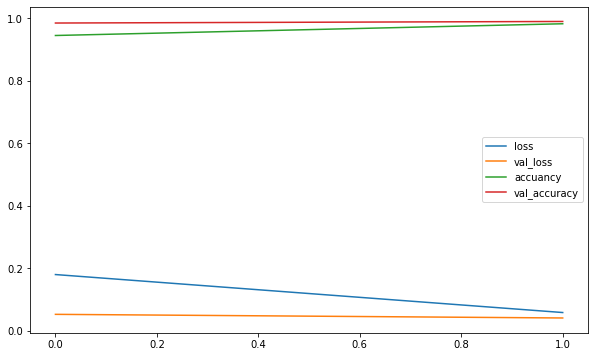

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
# 学習過程のプロット
plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")

plt.plot(history.epoch, history.history["accuracy"], label="accuancy")
plt.plot(history.epoch, history.history["val_accuracy"], label="val_accuracy")

plt.legend()

#### 精度評価

In [ ]:
# テストデータを用いた最終的、パフォーマンス計測
score = model.evaluate(x_test, 
                            y_test,
                            verbose=0
                            )
 
print("testデータでのloss：",score[0]) # lossの表示。
print("testデータでのaccuracy：",score[1]) # accuracyの表示。

testデータでのloss： 0.039242133498191833
testデータでのaccuracy： 0.9868999719619751


## 最後に確認
実際に未知のデータを与えて正しく分類分けできるか確かめてみましょう。

そして画像をモデルに読込むにはある程度の処理が必要ですよね。


①shapeを合わせる。（大きさの調整、色等）

②型(float)に調整

③1次元配列に変換

In [ ]:
# 画像読込

import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/img_9.jpg",cv2.IMREAD_GRAYSCALE)
#　この際に第二引数にて｢白黒｣で読み込む。という処理を致しております。

# これで表示。
cv2_imshow(img)

#google colab以外
# cv2.imshow("画像タイトル名前つけ", 変数名)

<font color="red">**ポイント**</font>

今回モデルに学習させたデータは`(28, 28)`の画像ですよね。

そして私が読み込んだのは`(28, 28, 3)`。　⇒shapeが異なっています。この<font color="red">3</font>は何？って話。
　これは色の**RGB**です。

この要素があるからモデルに拒絶(エラー)されたのです。
`ValueError: cannot reshape array of size 2352 into shape (1,784)`

<font color="red">2352</font> これは1次元配列した値`28*28*3=2352` 　そこから<font color="red">俺が読み込んだ画像colorじゃね？</font>と気づくことが出来ました。

だから画像を読み込む時に<font color="red">白黒で読み込んでください</font>という指示をしたわけですよ。⇒　これでちゃんとモデルに適合して予測を算出できます。という事。

predictの入力データ型は(データ数, 縦, 横, 色)である必要があるかと思いますが、このような4次元の形になっておりますでしょうか。場合によっては色が省略されて3次元になっている事もあると思います。


次元の追加や削除を行い、shapeを揃える事が重要です。

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
# 各画像のデータをモデルに適合させる。⇒そうすればエラーは起こらない。
img = img.reshape(1, 28,28)
img.shape 

(1, 28, 28)

In [ ]:
# 分類機に入力データを与えて予測（出力：各クラスの予想確率）
predict_y = model.predict(img)
print(predict_y)
print()
# 最も確率の高い要素番号（=予想する数字）
predict_number = np.argmax(predict_y)
print("predict_number:", predict_number)  # 予測した数字

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

predict_number: 3
